#1.Імпорт і формування вибірки

Імпорт необхідних бібліотек

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import PIL.Image
import os
import random
import scipy.stats as st
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Для псевдовипадкового формування вибірки зображень застосовано звичайну функцію random(), оскільки в її основі лежить генератор Мерсена (згідно з документацією). Стартове значення - 2.
Формування доволі тривіальне: спершу генерується 250 чисел із 25000, потім з архіву один раз вилучається папка mirflickr на Google Диск із зображеннями із номерами, відповідним цим 250-м числам, які у свою чергу конвертуються в numpy-масиви і в подальшому зберігаються в іншому масиві із назвою imgs. 


In [0]:
#generating random 250 numbers 
# rand_nums=[]
# random.seed(2)
# for i in range(251):
#   n = random.randint(1, 25000)
#   rand_nums.append(n)

#extracting images from archive into google drive
# def extractImgs(nums):
#   archive=ZipFile('/content/gdrive/My Drive/mirflickr25k.zip', 'r')
#   for i in nums:
#     path='mirflickr/im'+str(i)+'.jpg'
#     archive.extract(path, '/content/gdrive/My Drive/')
#   archive.close()

# extractImgs(rand_nums)

In [0]:
#converting images to arrays and appending them into list
def getImgs(path):
  imgs=[] 
  for img in os.listdir(path):
    imgs.append(np.array(PIL.Image.open(path+img)))
    
  return np.asarray(imgs)

imgs= getImgs('/content/drive/My Drive/mirflickr/')
print('Sampled {} RGB-images'.format(len(imgs)))

Sampled 250 RGB-images


In [0]:
imgs[0]

array([[[ 31,  32,  24],
        [ 22,  31,  26],
        [ 36,  43,  71],
        ...,
        [ 16,  23,  39],
        [ 16,  23,  39],
        [ 16,  23,  39]],

       [[ 17,  25,  14],
        [ 26,  34,  45],
        [ 37,  43,  69],
        ...,
        [ 17,  24,  40],
        [ 17,  24,  40],
        [ 17,  24,  40]],

       [[ 19,  25,  11],
        [ 22,  31,  36],
        [ 24,  33,  50],
        ...,
        [ 16,  23,  39],
        [ 17,  23,  39],
        [ 17,  23,  39]],

       ...,

       [[ 52,   3,   0],
        [ 53,   0,   3],
        [ 63,   8,   5],
        ...,
        [ 37,   4,   0],
        [ 33,   8,   4],
        [ 78,  12,  13]],

       [[ 58,   0,   0],
        [ 53,   1,   5],
        [ 67,   1,   5],
        ...,
        [ 45,   0,   1],
        [ 51,   6,   3],
        [135,  13,  12]],

       [[ 57,   0,   4],
        [ 44,   3,   1],
        [ 55,   4,   1],
        ...,
        [ 73,   0,   0],
        [ 77,   3,   2],
        [155,   3,   2]]

# 2. Характеристики розподілу для зеленого каналу

Формування масиву, що містить значення яскравості пікселів зеленого каналу всієї вибірки зображень, а також двохвимірного масиву, що містить в собі масиви значень яскравості пікселів зеленого каналу кожного зображення.

In [0]:
#green_values contains green-pixel-intensities of all sample 
green_all = []
green_img_list=[]
for i in range(len(imgs)):
  img = imgs[i].flatten()
  n = len(img)
  k=len(green_all)
  for green in range(1, n, 3):
    green_all.append(img[green])
  green_img_list.append(np.array(green_all[k:k+int(np.floor(n/3))]))

green_all = np.array(green_all)
green_img_list = np.array(green_img_list)

In [0]:
green_img_binned_list =[]
green_all_binned = np.bincount(green_all)
for green_img in green_img_list:
  green_img_binned_list.append(np.bincount(green_img))

In [0]:
len(green_all)

44388219

Математичне очікування та дисперсія

In [0]:
expect_green = np.mean(green_all)
var_green = np.var(green_all)
print('Expected value and variance of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(expect_green, var_green))

Expected value and variance of pixel intensity of green channel of all 250 images are 101.77400161065259 and 5545.282938782499 respectively


Медіана та інтерквартальний розмах

In [0]:
median_green = np.median(green_all)

q75, q25 = np.percentile(green_all, [75 ,25])
iqr_green = q75 - q25
print('Median and interquartile range of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(medi_green, iqr_green))

Median and interquartile range of pixel intensity of green channel of all 250 images are 96.0 and 126.0 respectively


Отже, значення, що лежать на відстані, більшій ніж півтора інтерквартильних діапазона від 1-го або ж 3-го квартиля, вважаються викидами. Проте розрахунки нижче вказують на те, що таких немає, оскільки q25-1.5iqr<0, а q75+1.5iqr>255.

In [0]:
print('We consider pixel intensity values to be outliers if they are below {} or above {}, but the values are far beyond valid range for pixel intensity.'.format(q25-1.5*iqr_green, q75+1.5*iqr_green))

We consider pixel intensity values to be outliers if they are below -156.0 or above 348.0, but the values are far beyond valid range for pixel intensity.


Коефіцієнти асиметрії та ексцесу (нормалізований)

In [0]:
skew_green = st.skew(green_all)
kurt_green = st.kurtosis(green_all)-3
print('Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are {} and {} respectively'.format(skew_green, kurt_green))

Skewness and normalized kurtosis of pixel intensity of green channel of all 250 images are 0.3212877038756634 and -4.0173482995522924 respectively


Нормалізована гістограма значень яскравості пікселів

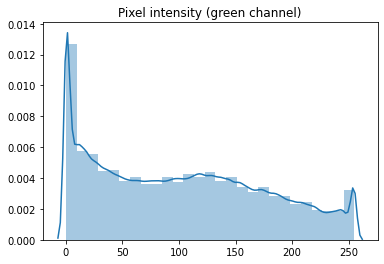

In [0]:
plt.title('Pixel intensity (green channel)')
sns.distplot(green_all, bins=27, norm_hist = True)

#3.Обробка отриманих гістограм

##a. Апроксимація гістограми

Провела апроксимацію гістограми вибірки всіх значень яскравості пікселів кривою нормального, Лапласового, Стьюдентового та бета- розподілу.

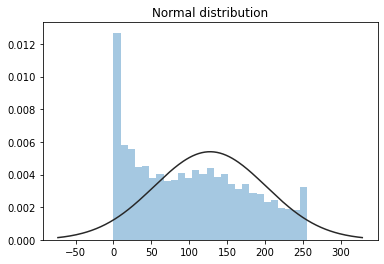

In [0]:
plt.title("Normal distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.norm,kde=False) 

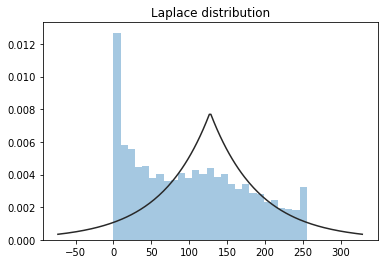

In [0]:
plt.title("Laplace distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.laplace,kde=False) 

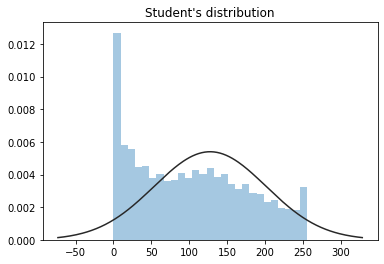

In [0]:
plt.title("Student's distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.t,kde=False) 

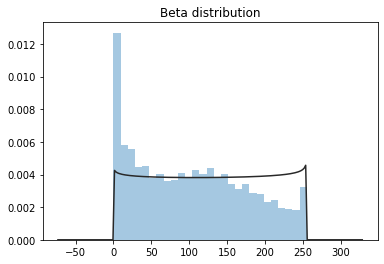

In [0]:
plt.title("Beta distribution")
sns.distplot(np.arange(256), bins=27, hist_kws={'weights':green_all_binned},norm_hist=True,fit=st.beta,kde=False) 

# Додаткові завдання (Murphy)

## 4.2

Uncorrelated and Gaussian does not imply independent unless jointly Gaussian.

Let X ∼ N (0, 1) and Y = W X, where p(W = −1) = p(W = 1) = 0.5. It is clear that X and Y are
not independent, since Y is a function of X.

**a. Show Y ∼ N (0, 1).**

Визначимо функцію щільності p(Y).

Оскільки за умовою Y=WX, то p(Y) = p(WX) = a) p(X), W=1 або b) p(-X), W=-1.

Але
$p(-X) = \frac{1}{{\sqrt {2\pi }}}e^{\frac{-(-x)^2}{2}} = p(X)$, тобто функція щільності p(X) - парна, тому p(Y)=p(X), що означає, що випадкову величину Y характеризує та сама функція щільності, що і X ~ N(0, 1). Отже, Y ~ N(0, 1). 







**b.Show cov [X, Y]=0. Thus X and Y are uncorrelated but dependent, even though they are Gaussian.**

**Hint**: use the definition of covariance
cov[X, Y] = E[XY] − E [X]E[Y]

and the rule of iterated expectation
E [XY] = E [E [XY|W]] 

cov[X, Y] = E[XY] − E [X]E[Y] = |за правилом повного математичного сподівання (iterated expectation) і оскільки E[X]=E[Y]=0, бо X, Y ~ N(0, 1)|= 0.5E[XY|W=1]+0.5E[XY|W=-1] = 0.5E[X*1*X] + 0.5E[X*(-1)*X] = 0.5(E[$X^2$] + E[$-X^2$]) = |лінійність математичного сподівання| =  0.5(E[$X^2$] - E[$X^2$]) = 0.

Отже, випадкові величини X і Y не корелюють, хоча є залежними і мають нормальний розподіл.